In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.preprocessing import StandardScaler, label_binarize, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Define file paths
shelter_data_24 = pd.read_csv("animalshelterdata_fy2425.csv")
shelter_data_23 = pd.read_csv("animalshelterdata_fy2324.csv")
shelter_data_22 = pd.read_csv("animalshelterdata_fy2223.csv")
shelter_data_21 = pd.read_csv("animalshelterdata_fy2122.csv")
shelter_data_20 = pd.read_csv("animalshelterdata_fy2021.csv")
shelter_data_19 = pd.read_csv("animalshelterdata_fy1920.csv")
shelter_data_18 = pd.read_csv("animalshelterdata_fy1819.csv")
shelter_data = pd.concat([shelter_data_24, shelter_data_23, shelter_data_22, shelter_data_21, shelter_data_20, 
        shelter_data_19, shelter_data_18])

## Data Cleaning

In [4]:
shelter_data = pd.concat([shelter_data_24, shelter_data_23, shelter_data_22, shelter_data_21, shelter_data_20, 
        shelter_data_19, shelter_data_18])

valid_outcomes = ['ADOPTION', 'FOSTER', 'DEAD', 'EUTH', 'RESCUE']
shelter_data_filtered = shelter_data[shelter_data['OutcomeType'].isin(valid_outcomes)]

for intake, outcome in [('FOSTER', 'ADOPTION'), ('FOSTER', 'RESCUE'), ('FOSTER', 'FOSTER')]:
    shelter_data_filtered = shelter_data_filtered[~((shelter_data_filtered['IntakeType'] == intake) & 
                                                     (shelter_data_filtered['OutcomeType'] == outcome))]

# remove duplicates
shelter_data_filtered_no_dupes = shelter_data_filtered.drop_duplicates(subset='AnimalID', keep='first').copy()

# fix error
shelter_data_filtered_no_dupes.loc[shelter_data_filtered_no_dupes['AnimalID'] == 'A1334166', 'OutcomeDate'] = '2024-03-31'

In [5]:
shelter_data_filtered_no_dupes['IntakeDate'] = pd.to_datetime(shelter_data_filtered_no_dupes['IntakeDate'])
shelter_data_filtered_no_dupes['OutcomeDate'] = pd.to_datetime(shelter_data_filtered_no_dupes['OutcomeDate'])

# extract year, month, day from IntakeDate
shelter_data_filtered_no_dupes['IntakeYear'] = shelter_data_filtered_no_dupes['IntakeDate'].dt.year
shelter_data_filtered_no_dupes['IntakeMonth'] = shelter_data_filtered_no_dupes['IntakeDate'].dt.month
shelter_data_filtered_no_dupes['IntakeDay'] = shelter_data_filtered_no_dupes['IntakeDate'].dt.day

shelter_data_filtered_no_dupes['OutcomeYear'] = shelter_data_filtered_no_dupes['OutcomeDate'].dt.year
shelter_data_filtered_no_dupes['OutcomeMonth'] = shelter_data_filtered_no_dupes['OutcomeDate'].dt.month
shelter_data_filtered_no_dupes['OutcomeDay'] = shelter_data_filtered_no_dupes['OutcomeDate'].dt.day

# calculate Time Spent In Shelter
shelter_data_filtered_no_dupes['Time_Spent_In_Shelter'] = shelter_data_filtered_no_dupes['OutcomeDate'] - shelter_data_filtered_no_dupes['IntakeDate']
shelter_data_filtered_no_dupes['Time_Spent_In_Shelter_Days'] = shelter_data_filtered_no_dupes['Time_Spent_In_Shelter'].dt.days

# sanity check
shelter_data_filtered_no_dupes['Is_Outcome_After_Intake'] = shelter_data_filtered_no_dupes['OutcomeDate'] >= shelter_data_filtered_no_dupes['IntakeDate']

# convert Age to numeric 
shelter_data_filtered_no_dupes['Age_Numeric'] = pd.to_numeric(shelter_data_filtered_no_dupes['Age'].str.extract('(\d+)')[0], errors='coerce')

# drop unnecessary columns
columns_to_drop = ['LastUpdate', 'IntakeDate', 'OutcomeDate', 'Age', 'Time_Spent_In_Shelter','Is_Outcome_After_Intake',
                  'Crossing','OutcomeSubtype', 'OutcomeCondition', 'DOB'  ]
shelter_data_filtered_no_dupes.drop(columns=columns_to_drop, inplace=True)
data = shelter_data_filtered_no_dupes
data

#data = pd.read_csv('cleaned_shelter_data_for_models.csv')

,AnimalID,AnimalName,AnimalType,PrimaryColor,SecondaryColor,PrimaryBreed,Sex,IntakeCondition,IntakeType,IntakeSubtype,IntakeReason,OutcomeType,Jurisdiction,IntakeYear,IntakeMonth,IntakeDay,OutcomeYear,OutcomeMonth,OutcomeDay,Time_Spent_In_Shelter_Days,Age_Numeric
2,A0569573,SHALE,CAT,BLACK,NaN,DOMESTIC SH,SPAYED,MED SEV,STRAY,OTC,NaN,EUTH,SAN JOSE,2024,9,25,2024.0,9.0,25.0,0.0,16.0
10,A0719419,NaN,CAT,TABBY-BRN,WHITE,DOMESTIC SH,NEUTERED,MED R,STRAY,OTC,NaN,EUTH,SAN JOSE,2024,8,20,2024.0,8.0,20.0,0.0,NaN
13,A0742526,JEWELS,DOG,WHITE,TAN,CHIHUAHUA SH,NEUTERED,HEALTHY,STRAY,OTC,NaN,RESCUE,SAN JOSE,2024,9,24,2024.0,9.0,30.0,6.0,13.0
18,A0776196,NaN,CAT,PT-LYNX,NaN,DOMESTIC SH,SPAYED,MED SEV,STRAY,OTC,NaN,EUTH,SAN JOSE,2024,7,12,2024.0,7.0,12.0,0.0,NaN
24,A0820993,NaN,CAT,TABBY-ORG,NaN,DOMESTIC SH,NEUTERED,AGGRESSIVE,STRAY,OTC,NaN,EUTH,SAN JOSE,2024,9,11,2024.0,9.0,11.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21586,A1193594,MARSHMALLOW,CAT,WHITE,BROWN TIPS,DOMESTIC SH,NEUTERED,NORMAL,STRAY,OTC,NaN,ADOPTION,SAN JOSE,2018,8,21,2018.0,8.0,26.0,5.0,6.0
21588,A1196120,DORIS,DOG,BROWN,NaN,PIT BULL,SPAYED,NORMAL,STRAY,OTC,NaN,ADOPTION,SAN JOSE,2019,6,21,2019.0,8.0,17.0,57.0,9.0
21595,A1224961,BAILEY,DOG,WHITE,TAN,BORDER COLLIE,SPAYED,NORMAL,OWNER SUR,OTC,ALLERGIC,ADOPTION,SAN JOSE,2019,3,9,2019.0,3.0,12.0,3.0,6.0
21609,A1262798,LUCIFER,CAT,TABBY-BRN,NaN,DOMESTIC SH,SPAYED,NORMAL,OWNER SUR,OTC,MOVE,ADOPTION,SAN JOSE,2019,4,26,2019.0,5.0,1.0,5.0,NaN


## EDA

In [6]:
# examine the summary statistics
data.describe()

,IntakeYear,IntakeMonth,IntakeDay,OutcomeYear,OutcomeMonth,OutcomeDay,Time_Spent_In_Shelter_Days,Age_Numeric
count,50570.000000,50570.000000,50570.000000,50567.000000,50567.000000,50567.000000,50567.000000,33425.000000
mean,2020.984635,6.715048,15.545620,2021.010303,6.861629,15.634564,14.027409,5.351563
std,1.935661,2.942782,8.789479,1.944182,3.018253,8.732986,28.847523,3.661419
min,2018.000000,1.000000,1.000000,2018.000000,1.000000,1.000000,0.000000,0.000000
25%,2019.000000,5.000000,8.000000,2019.000000,5.000000,8.000000,1.000000,3.000000
50%,2021.000000,7.000000,15.000000,2021.000000,7.000000,16.000000,6.000000,5.000000
75%,2023.000000,9.000000,23.000000,2023.000000,9.000000,23.000000,15.000000,7.000000
max,2024.000000,12.000000,31.000000,2024.000000,12.000000,31.000000,726.000000,40.000000


In [7]:
# Check for missing values
print("\nMissing Values per Column:")
print(data.isnull().sum())


Missing Values per Column:
AnimalID                          0
AnimalName                    24677
AnimalType                        0
PrimaryColor                      0
SecondaryColor                29124
PrimaryBreed                      0
Sex                               0
IntakeCondition                   0
IntakeType                        0
IntakeSubtype                   390
IntakeReason                  46786
OutcomeType                       0
Jurisdiction                   1393
IntakeYear                        0
IntakeMonth                       0
IntakeDay                         0
OutcomeYear                       3
OutcomeMonth                      3
OutcomeDay                        3
Time_Spent_In_Shelter_Days        3
Age_Numeric                   17145
dtype: int64


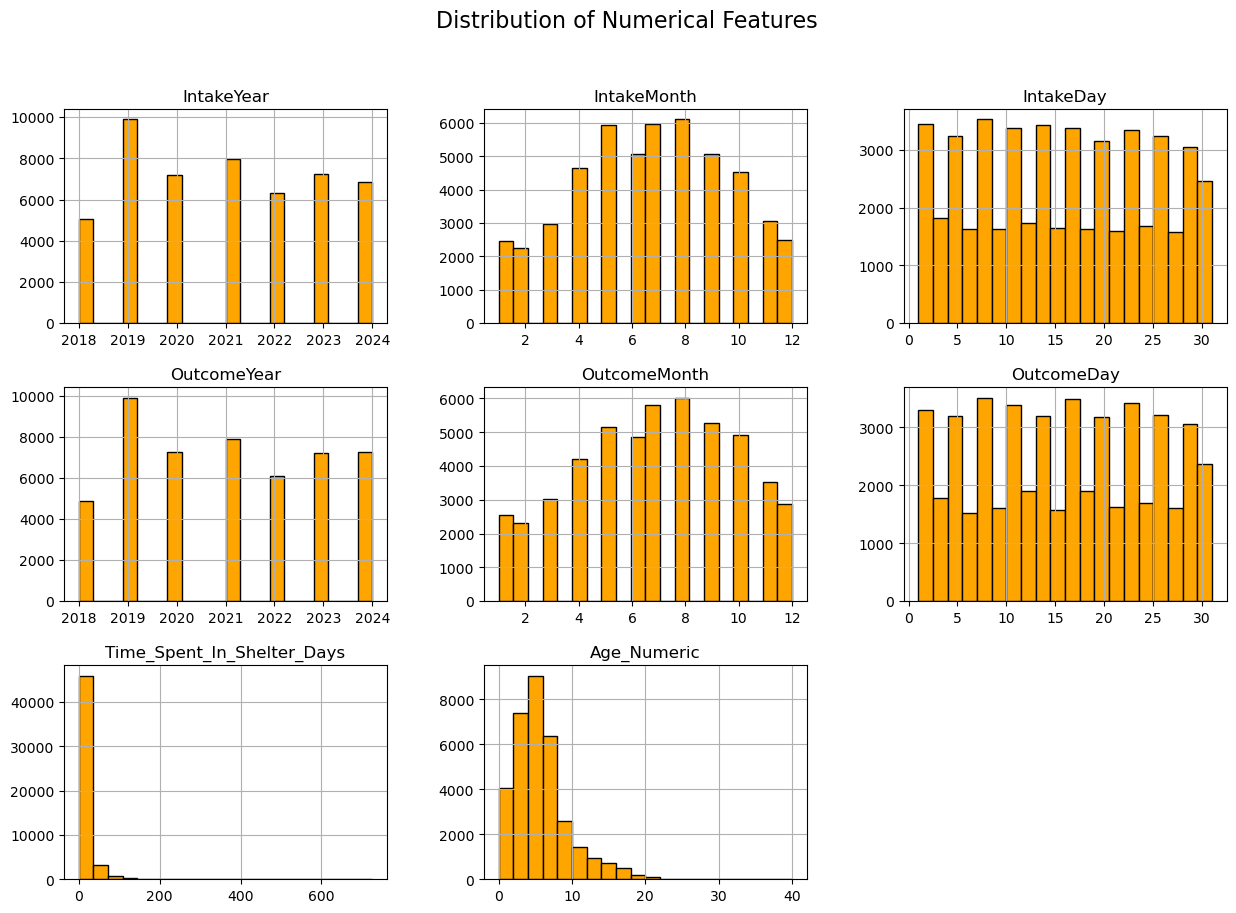

In [8]:
# Plot distribution of numerical features
data.select_dtypes(include='number').hist(bins=20, figsize=(15, 10), color='orange', edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

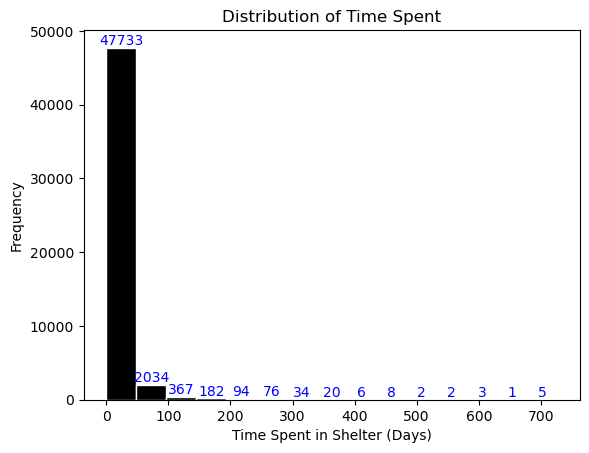

In [21]:
# Group by Time_Spent_In_Shelter_Days and count total
counts, bins, patches = plt.hist(data['Time_Spent_In_Shelter_Days'], bins=15, color='black', edgecolor='white')

for count, bin_edge in zip(counts, bins[:-1]):  
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), 
             ha='center', va='bottom', fontsize=10, color='blue')

plt.title('Distribution of Time Spent')
plt.xlabel('Time Spent in Shelter (Days)')
plt.ylabel('Frequency')
plt.show()

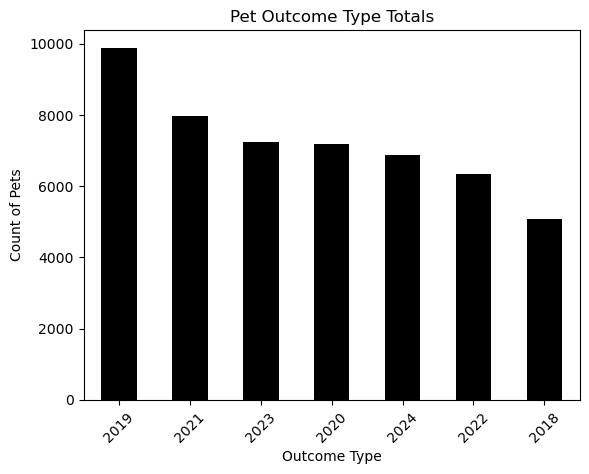

In [10]:
# Group by IntakeYear and count total pets
outcome_counts = data['IntakeYear'].value_counts()

# Plotting the bar chart
outcome_counts.plot(kind='bar', color='black')
plt.title('Pet Outcome Type Totals')
plt.xlabel('Outcome Type')
plt.ylabel('Count of Pets')
plt.xticks(rotation=45)
plt.show()

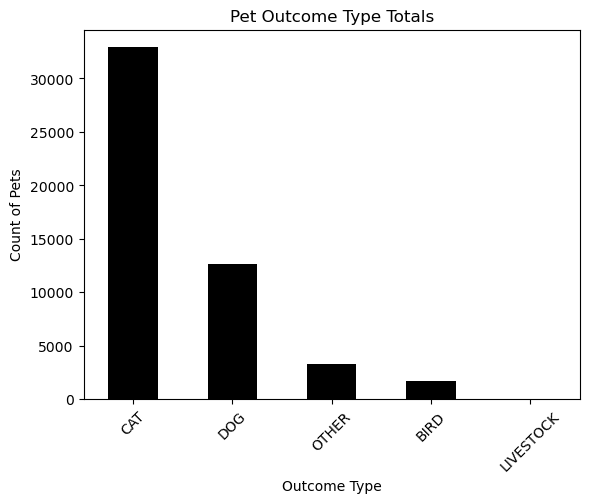

In [11]:
# Group by IntakeYear and count total pets
outcome_counts = data['AnimalType'].value_counts()

# Plotting the bar chart
outcome_counts.plot(kind='bar', color='black')
plt.title('Pet Outcome Type Totals')
plt.xlabel('Outcome Type')
plt.ylabel('Count of Pets')
plt.xticks(rotation=45)
plt.show()

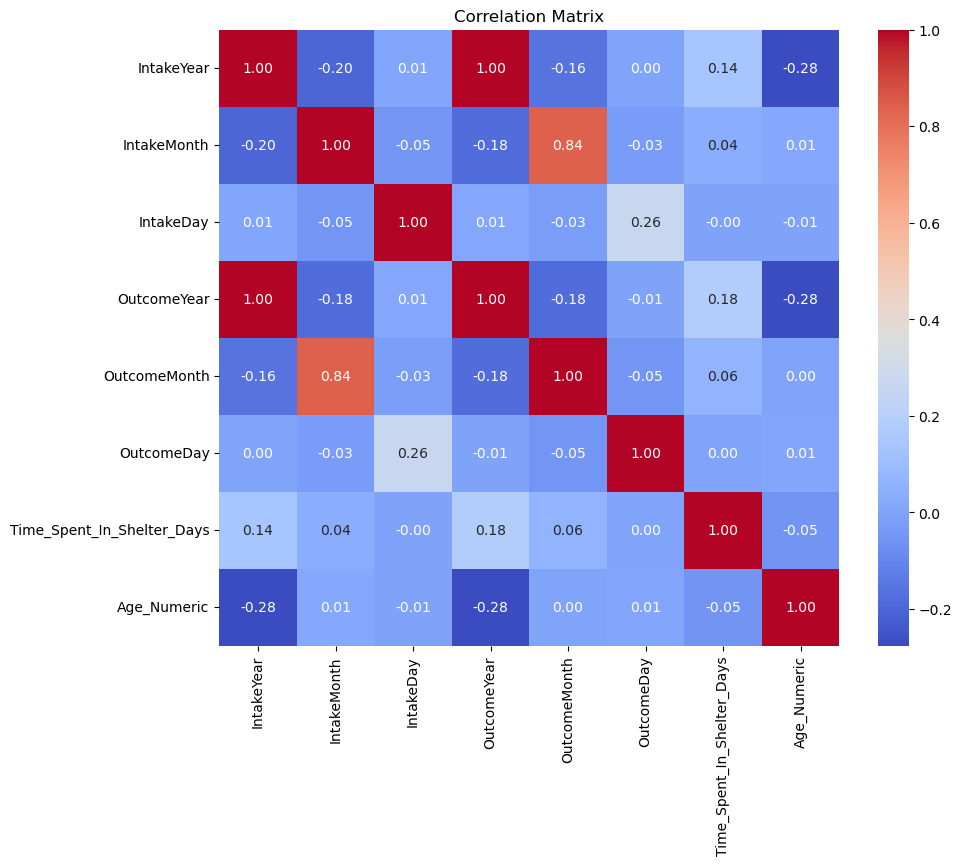

In [10]:
# Correlation Matrix for Numerical Variables
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

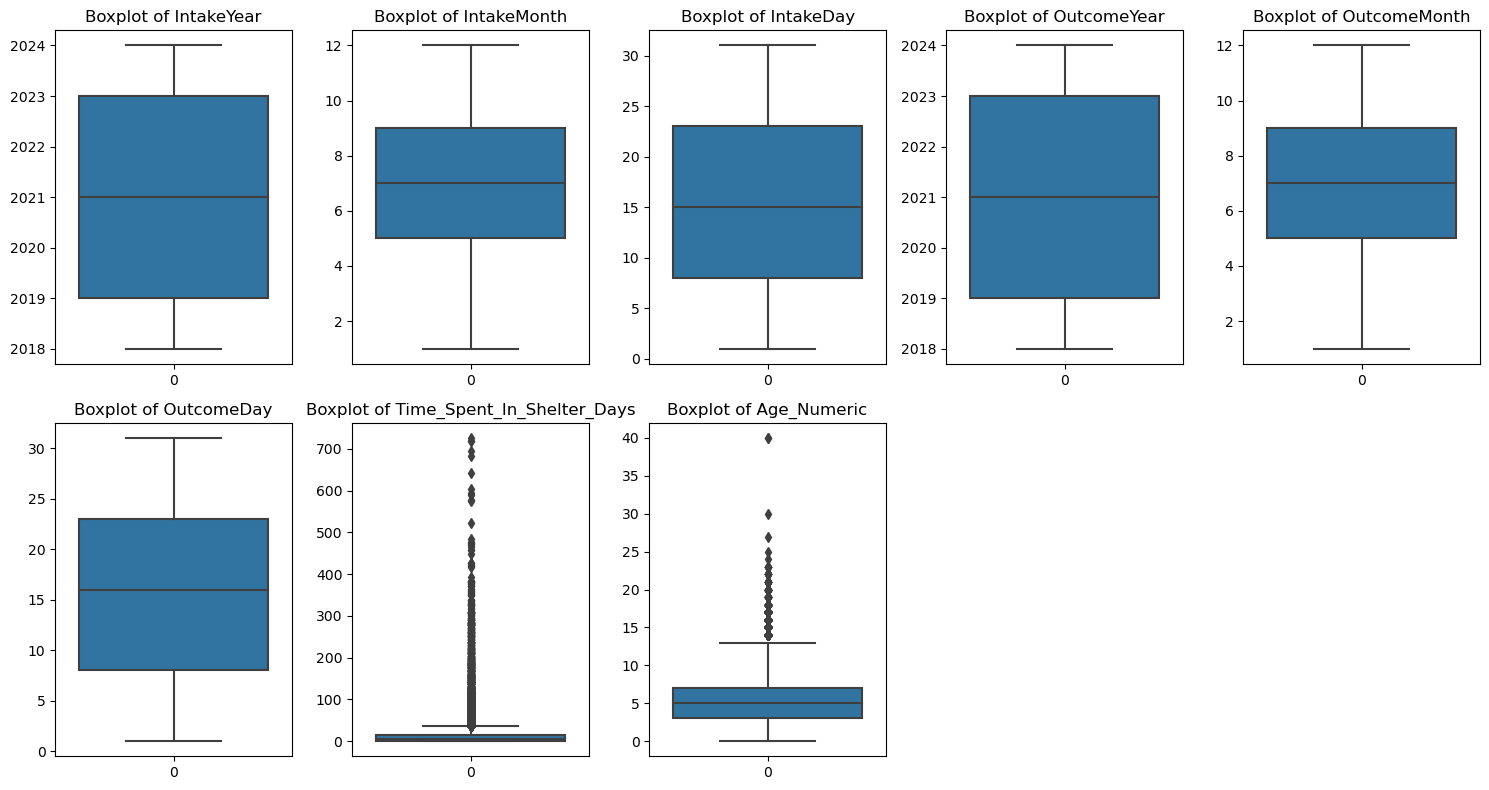

In [11]:
# Identifying Outliers (Boxplot)
numerical_cols = data.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, len(numerical_cols)//2 + 1, i)
    sns.boxplot(data[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

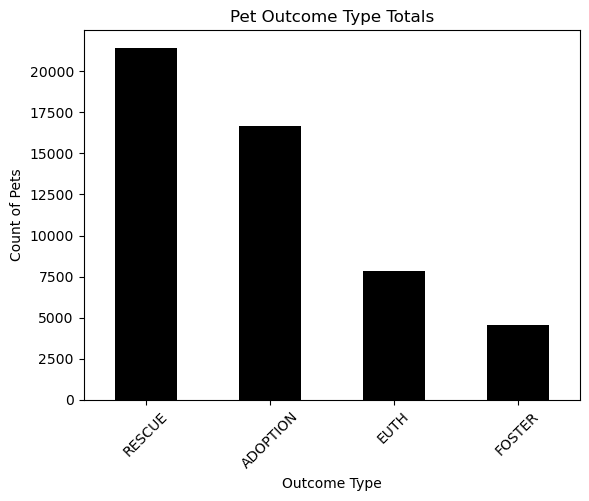

In [12]:
# Group by OutcomeType and count total pets by OutcomeType
outcome_counts = data['OutcomeType'].value_counts()

# Plotting the bar chart
outcome_counts.plot(kind='bar', color='black')
plt.title('Pet Outcome Type Totals')
plt.xlabel('Outcome Type')
plt.ylabel('Count of Pets')
plt.xticks(rotation=45)
plt.show()

In [13]:
# I will do undersampling on the majority classes

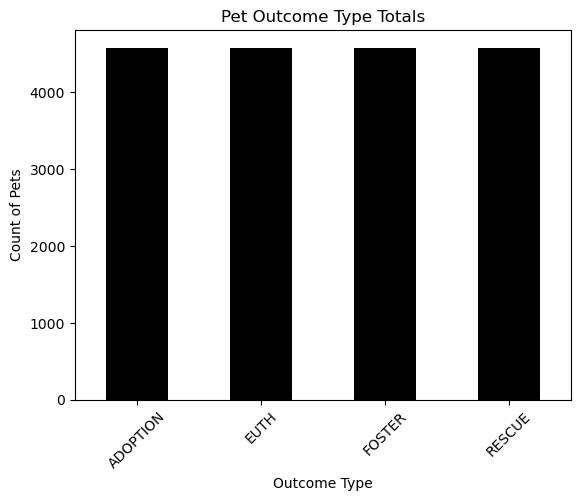

In [14]:
# this will find the least frequent class
min_class = data['OutcomeType'].value_counts().min()

# Do undersampling
data = (data.groupby('OutcomeType').apply(lambda x: x.sample(n=min_class, random_state=4))
    .reset_index(drop=True)
)
# check size again
outcome_counts = data['OutcomeType'].value_counts()

# Plotting the bar chart
outcome_counts.plot(kind='bar', color='black')
plt.title('Pet Outcome Type Totals')
plt.xlabel('Outcome Type')
plt.ylabel('Count of Pets')
plt.xticks(rotation=45)
plt.show()

In [15]:
columns_to_encode = ['PrimaryColor', 'SecondaryColor', 'PrimaryBreed', 'Sex', 'IntakeCondition', 'IntakeType',
                     'IntakeReason', 'Jurisdiction']
data = pd.get_dummies(data, columns=columns_to_encode, drop_first=True)
data

,AnimalID,AnimalName,AnimalType,IntakeSubtype,OutcomeType,IntakeYear,IntakeMonth,IntakeDay,OutcomeYear,OutcomeMonth,OutcomeDay,Time_Spent_In_Shelter_Days,Age_Numeric,PrimaryColor_BLUE,PrimaryColor_BRINDLE-BN,PrimaryColor_BRINDLE-LN,PrimaryColor_BRINDLE-TN,PrimaryColor_BRN TABBY,PrimaryColor_BROWN,PrimaryColor_BUFF,PrimaryColor_CALICO-DIL,PrimaryColor_CALICO-TRI,PrimaryColor_CHOCOLATE,PrimaryColor_CREAM,PrimaryColor_FAWN,PrimaryColor_GOLD,PrimaryColor_GRAY,PrimaryColor_GREEN,PrimaryColor_LIVER,PrimaryColor_LYNX PT,PrimaryColor_MERLE-BLUE,PrimaryColor_MERLE-RED,PrimaryColor_ORANGE,PrimaryColor_OTHER,PrimaryColor_PT-CHOC,PrimaryColor_PT-FLAME,PrimaryColor_PT-LILAC,PrimaryColor_PT-LYNX,PrimaryColor_PT-SEAL,PrimaryColor_RED,PrimaryColor_SABLE,PrimaryColor_SHADE-SLV,PrimaryColor_SHADE-SMK,PrimaryColor_TABBY-BRN,PrimaryColor_TABBY-BUFF,PrimaryColor_TABBY-GRAY,PrimaryColor_TABBY-ORG,PrimaryColor_TABBY-RED,PrimaryColor_TAN,PrimaryColor_TICK-BLACK,PrimaryColor_TICK-BLUE,PrimaryColor_TORBI-BRN,PrimaryColor_TORBI-DIL,PrimaryColor_TORTIE-B\O,PrimaryColor_TORTIE-DIL,PrimaryColor_TRICOLOR,PrimaryColor_WHITE,PrimaryColor_YELLOW,SecondaryColor_BLUE,SecondaryColor_BRINDLE-BN,SecondaryColor_BROWN,SecondaryColor_BROWN TIPS,SecondaryColor_BUFF,SecondaryColor_CALICO-DIL,SecondaryColor_CALICO-TRI,SecondaryColor_CHOCOLATE,SecondaryColor_CREAM,SecondaryColor_FAWN,SecondaryColor_GOLD,SecondaryColor_GRAY,SecondaryColor_GREEN,SecondaryColor_MERLE-BLUE,SecondaryColor_MERLE-RED,SecondaryColor_ORANGE,SecondaryColor_OTHER,SecondaryColor_PT-CHOC,SecondaryColor_PT-FLAME,SecondaryColor_PT-LILAC,SecondaryColor_PT-SEAL,SecondaryColor_RED,SecondaryColor_SABLE,SecondaryColor_SHADE-SMK,SecondaryColor_TABBY-BRN,SecondaryColor_TABBY-GRAY,SecondaryColor_TABBY-ORG,SecondaryColor_TAN,SecondaryColor_TORBI-BRN,SecondaryColor_TORTIE-B\O,SecondaryColor_TORTIE-DIL,SecondaryColor_TRICOLOR,SecondaryColor_WHITE,SecondaryColor_YELLOW,PrimaryBreed_AKBASH,PrimaryBreed_AKITA,PrimaryBreed_ALASK KLEE KAI,PrimaryBreed_ALASK MALAMUTE,PrimaryBreed_ALASKAN HUSKY,PrimaryBreed_AM PIT BULL TER,PrimaryBreed_AMER BULLDOG,PrimaryBreed_AMER CURL SH,PrimaryBreed_AMER ESKIMO,PrimaryBreed_AMER FOXHOUND,PrimaryBreed_AMER SH,PrimaryBreed_AMERICAN STAFF,PrimaryBreed_ANATOL SHEPHERD,PrimaryBreed_AUST CATTLE DOG,PrimaryBreed_AUST KELPIE,PrimaryBreed_AUST SHEPHERD,PrimaryBreed_BADGER,PrimaryBreed_BASENJI,PrimaryBreed_BASSET HOUND,PrimaryBreed_BAT,PrimaryBreed_BEAGLE,PrimaryBreed_BEARDED COLLIE,PrimaryBreed_BELG MALINOIS,PrimaryBreed_BELG SHEEPDOG,PrimaryBreed_BELGIAN HARE,PrimaryBreed_BENGAL,PrimaryBreed_BERNESE MTN DOG,PrimaryBreed_BICHON FRISE,PrimaryBreed_BLACK MOUTH CUR,PrimaryBreed_BLOODHOUND,PrimaryBreed_BLUEBIRD,PrimaryBreed_BOBCAT,PrimaryBreed_BOERBOEL,PrimaryBreed_BOMBAY,PrimaryBreed_BORDER COLLIE,PrimaryBreed_BORDER TERRIER,PrimaryBreed_BOSTON TERRIER,PrimaryBreed_BOXER,PrimaryBreed_BRITISH SH,PrimaryBreed_BRUSS GRIFFON,PrimaryBreed_BUDGERIGAR,PrimaryBreed_BULL TERRIER,PrimaryBreed_BULLDOG,PrimaryBreed_BULLMASTIFF,PrimaryBreed_BURMESE,PrimaryBreed_CAIRN TERRIER,PrimaryBreed_CALIFORNIAN,PrimaryBreed_CANAAN DOG,PrimaryBreed_CANARY,PrimaryBreed_CANE CORSO,PrimaryBreed_CAROLINA DOG,PrimaryBreed_CATAHOULA,PrimaryBreed_CAVALIER SPAN,PrimaryBreed_CHESA BAY RETR,PrimaryBreed_CHICKEN,PrimaryBreed_CHIHUAHUA LH,PrimaryBreed_CHIHUAHUA LONG,PrimaryBreed_CHIHUAHUA SH,PrimaryBreed_CHINESE CRESTED,PrimaryBreed_CHINESE SHARPEI,PrimaryBreed_CHOW CHOW,PrimaryBreed_CLUMBER SPAN,PrimaryBreed_COCKATIEL,PrimaryBreed_COCKER SPAN,PrimaryBreed_COLD WATER,PrimaryBreed_COLLIE ROUGH,PrimaryBreed_COLLIE SMOOTH,PrimaryBreed_COLORPOINT,PrimaryBreed_CONURE,PrimaryBreed_COOT,PrimaryBreed_COYOTE,PrimaryBreed_CROW,PrimaryBreed_DACHSHUND,PrimaryBreed_DACHSHUND CHIHU,PrimaryBreed_DACHSHUND LH,PrimaryBreed_DACHSHUND WH,PrimaryBreed_DALMATIAN,PrimaryBreed_DANDIE DINMONT,PrimaryBreed_DEER,PrimaryBreed_DEVON REX,PrimaryBreed_DOBERMAN PINSCH,PrimaryBreed_DOGO ARGENTINO,PrimaryBreed_DOGUE DE BORDX,PrimaryBreed_DOMESTIC LH,PrimaryBreed_DO

## Data Modeling 

In [16]:
# Check for missing values
print("\nMissing Values per Column:")
missing_values = data.isnull().sum()
missing_columns = missing_values[missing_values > 0]
missing_columns


Missing Values per Column:


AnimalName                    8838
IntakeSubtype                  163
OutcomeYear                      3
OutcomeMonth                     3
OutcomeDay                       3
Time_Spent_In_Shelter_Days       3
Age_Numeric                   6421
dtype: int64

#### Training / Testing Split

In [17]:
X = data.drop(['OutcomeType', 'AnimalID', 'AnimalName', 'AnimalType', 'IntakeSubtype', 'IntakeSubtype', 'OutcomeYear', 
              'OutcomeMonth', 'OutcomeDay', 'Time_Spent_In_Shelter_Days', 'Age_Numeric'], axis=1)  
y = data['OutcomeType']  # Define the target variable

# Splitting into training, validation, testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2014)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2013)

## Guassian NB

In [18]:
# baseline
# Initialize Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_test = gnb.predict(X_test)
print("Gaussian NB")
print(classification_report(y_test, y_pred_test))

Gaussian NB
              precision    recall  f1-score   support

    ADOPTION       0.56      0.07      0.13       682
        EUTH       0.41      0.70      0.51       722
      FOSTER       0.51      0.94      0.66       683
      RESCUE       0.55      0.14      0.22       661

    accuracy                           0.47      2748
   macro avg       0.51      0.46      0.38      2748
weighted avg       0.51      0.47      0.39      2748



In [19]:
# Instantiate the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Define the hyperparameter grid
param_grid = {
    'priors': [None, [0.1, 0.9], [0.2, 0.8], [0.5, 0.5], [0.7, 0.3]],
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Perform hyperparameter tuning using GridSearchCV for 5-fold cross-validation
nb = GridSearchCV(gnb, param_grid, cv=5)  
nb.fit(X_val, y_val)

# Get the best hyperparameters found during tuning
best_params = nb.best_params_

# Create the final model using the best parameters
mod = GaussianNB(priors=best_params['priors'], var_smoothing=best_params['var_smoothing'])

# Train the final model on the entire training data
mod.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred_test = mod.predict(X_test)

# Print the classification report
print("Gaussian NB")
print(classification_report(y_test, y_pred_test))

Gaussian NB
              precision    recall  f1-score   support

    ADOPTION       0.52      0.21      0.30       682
        EUTH       0.47      0.73      0.57       722
      FOSTER       0.59      0.89      0.71       683
      RESCUE       0.48      0.24      0.32       661

    accuracy                           0.52      2748
   macro avg       0.52      0.52      0.48      2748
weighted avg       0.52      0.52      0.48      2748



In [20]:
best_params

{'priors': None, 'var_smoothing': 1e-05}

In [21]:
# Create the final model using the best parameters
mod = GaussianNB(**best_params)

# Train the final model on the entire training data
mod.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred_test = mod.predict(X_test)
print("Gaussian NB")
print(classification_report(y_test, y_pred_test))

Gaussian NB
              precision    recall  f1-score   support

    ADOPTION       0.52      0.21      0.30       682
        EUTH       0.47      0.73      0.57       722
      FOSTER       0.59      0.89      0.71       683
      RESCUE       0.48      0.24      0.32       661

    accuracy                           0.52      2748
   macro avg       0.52      0.52      0.48      2748
weighted avg       0.52      0.52      0.48      2748



## Multinomial Naive Bayes

In [22]:
# baseline
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_test = mnb.predict(X_test)
print("Multinomial NB")
print(classification_report(y_test, y_pred_test))

Multinomial NB
              precision    recall  f1-score   support

    ADOPTION       0.59      0.65      0.62       682
        EUTH       0.73      0.70      0.72       722
      FOSTER       0.62      0.82      0.70       683
      RESCUE       0.58      0.35      0.43       661

    accuracy                           0.63      2748
   macro avg       0.63      0.63      0.62      2748
weighted avg       0.63      0.63      0.62      2748



In [23]:
# Instantiate the Multinomial Naive Bayes classifier
mnb = MultinomialNB()

# Define the hyperparameter grid
param_grid = [{
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],  # Extended range for alpha
    'force_alpha': [True, False],
    'fit_prior': [True, False],
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]]  # Example for binary classification
}]
# Perform hyperparameter tuning using GridSearchCV
nb = GridSearchCV(mnb, param_grid, cv=5)  
nb.fit(X_val, y_val)

# Get the best hyperparameters found during tuning
best_params = nb.best_params_

# Predict on the test set using the best estimator found during tuning
best_estimator = nb.best_estimator_
y_pred_test = best_estimator.predict(X_test)

# Print the classification report
print("Multinomial NB")

print(classification_report(y_test, y_pred_test))

Multinomial NB
              precision    recall  f1-score   support

    ADOPTION       0.58      0.62      0.60       682
        EUTH       0.75      0.67      0.71       722
      FOSTER       0.61      0.80      0.69       683
      RESCUE       0.55      0.40      0.46       661

    accuracy                           0.62      2748
   macro avg       0.62      0.62      0.61      2748
weighted avg       0.62      0.62      0.62      2748



In [24]:
best_params

{'alpha': 1, 'class_prior': None, 'fit_prior': False, 'force_alpha': True}

In [25]:
mod = MultinomialNB(**best_params)

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)

print("Multinomial NB")

print(classification_report(y_test, y_pred_test))

Multinomial NB
              precision    recall  f1-score   support

    ADOPTION       0.59      0.65      0.62       682
        EUTH       0.73      0.71      0.72       722
      FOSTER       0.62      0.82      0.71       683
      RESCUE       0.58      0.34      0.43       661

    accuracy                           0.63      2748
   macro avg       0.63      0.63      0.62      2748
weighted avg       0.63      0.63      0.62      2748



## Bernoulli Naive Bayes

In [26]:
# baseline
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_pred_test = bnb.predict(X_test)
print("Bernoulli NB")

print(classification_report(y_test, y_pred_test))

Bernoulli NB
              precision    recall  f1-score   support

    ADOPTION       0.58      0.62      0.60       682
        EUTH       0.69      0.71      0.70       722
      FOSTER       0.61      0.82      0.70       683
      RESCUE       0.55      0.30      0.39       661

    accuracy                           0.62      2748
   macro avg       0.61      0.62      0.60      2748
weighted avg       0.61      0.62      0.60      2748



In [27]:
bnb = BernoulliNB()

param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3, 0.001, 0.01, 0.1, 1, 10],  # Extended range for alpha
    'binarize': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  # Extended binarization thresholds
    'fit_prior': [True, False],  # Learn class prior probabilities
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.5, 0.5], [0.3, 0.7]]  # Example class priors
}

nb = GridSearchCV(bnb, param_grid, cv=5)  
nb.fit(X_val, y_val)

best_params = nb.best_params_

mod = BernoulliNB(alpha=best_params['alpha'], binarize=best_params['binarize'],
                   fit_prior=best_params['fit_prior'], class_prior=best_params['class_prior'])

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)
print("Bernoulli NB")


print(classification_report(y_test, y_pred_test))

Bernoulli NB
              precision    recall  f1-score   support

    ADOPTION       0.58      0.62      0.60       682
        EUTH       0.69      0.72      0.70       722
      FOSTER       0.61      0.83      0.71       683
      RESCUE       0.56      0.30      0.39       661

    accuracy                           0.62      2748
   macro avg       0.61      0.62      0.60      2748
weighted avg       0.61      0.62      0.60      2748



In [28]:
best_params

{'alpha': 1, 'binarize': 0.0, 'class_prior': None, 'fit_prior': False}

In [29]:
mod = BernoulliNB(**best_params)

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)
print("Bernoulli NB")


print(classification_report(y_test, y_pred_test))

Bernoulli NB
              precision    recall  f1-score   support

    ADOPTION       0.58      0.62      0.60       682
        EUTH       0.69      0.72      0.70       722
      FOSTER       0.61      0.83      0.71       683
      RESCUE       0.56      0.30      0.39       661

    accuracy                           0.62      2748
   macro avg       0.61      0.62      0.60      2748
weighted avg       0.61      0.62      0.60      2748



## Complement Naive Bayes

In [30]:
# baseline
cnb = ComplementNB()
cnb.fit(X_train, y_train)

y_pred_test = cnb.predict(X_test)
print("Complement NB")

print(classification_report(y_test, y_pred_test))

Complement NB
              precision    recall  f1-score   support

    ADOPTION       0.57      0.61      0.59       682
        EUTH       0.64      0.79      0.71       722
      FOSTER       0.62      0.84      0.71       683
      RESCUE       0.67      0.20      0.31       661

    accuracy                           0.62      2748
   macro avg       0.62      0.61      0.58      2748
weighted avg       0.62      0.62      0.58      2748



In [31]:
cnb = ComplementNB()

# Define the hyperparameter grid
param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3, 0.1, 1, 10, 100],  # Extended range for alpha
    'fit_prior': [True, False],  # Learn class prior probabilities
    'norm': [True, False],  # Normalize probabilities
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.5, 0.5], [0.3, 0.7]]  # Example class priors
}

nb = GridSearchCV(cnb, param_grid, cv=5)  
nb.fit(X_val, y_val)

best_params = nb.best_params_

mod = ComplementNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'], norm=best_params['norm'])

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)
print("Complement NB")

print(classification_report(y_test, y_pred_test))

Complement NB
              precision    recall  f1-score   support

    ADOPTION       0.57      0.61      0.59       682
        EUTH       0.64      0.79      0.71       722
      FOSTER       0.62      0.84      0.71       683
      RESCUE       0.67      0.20      0.31       661

    accuracy                           0.62      2748
   macro avg       0.62      0.61      0.58      2748
weighted avg       0.62      0.62      0.58      2748



In [32]:
best_params

{'alpha': 1, 'class_prior': None, 'fit_prior': True, 'norm': False}

In [33]:
mod = ComplementNB(**best_params)

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)
print("Complement NB")

print(classification_report(y_test, y_pred_test))

Complement NB
              precision    recall  f1-score   support

    ADOPTION       0.57      0.61      0.59       682
        EUTH       0.64      0.79      0.71       722
      FOSTER       0.62      0.84      0.71       683
      RESCUE       0.67      0.20      0.31       661

    accuracy                           0.62      2748
   macro avg       0.62      0.61      0.58      2748
weighted avg       0.62      0.62      0.58      2748



## Best Model

In [34]:
# baseline
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_test = mnb.predict(X_test)
print("Multinomial NB")
print(classification_report(y_test, y_pred_test))

Multinomial NB
              precision    recall  f1-score   support

    ADOPTION       0.59      0.65      0.62       682
        EUTH       0.73      0.70      0.72       722
      FOSTER       0.62      0.82      0.70       683
      RESCUE       0.58      0.35      0.43       661

    accuracy                           0.63      2748
   macro avg       0.63      0.63      0.62      2748
weighted avg       0.63      0.63      0.62      2748



In [35]:
X = data.drop(['OutcomeType', 'AnimalID', 'AnimalName', 'AnimalType', 'IntakeSubtype', 'IntakeSubtype', 'OutcomeYear', 
              'OutcomeMonth', 'OutcomeDay', 'Time_Spent_In_Shelter_Days', 'Age_Numeric'], axis=1)  
y = data['OutcomeType']  # Define the target variable

classes = y.unique()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

mod = MultinomialNB()
    
mod.fit(X_train, y_train)

y_pred_prob_test = mod.predict_proba(X_test)

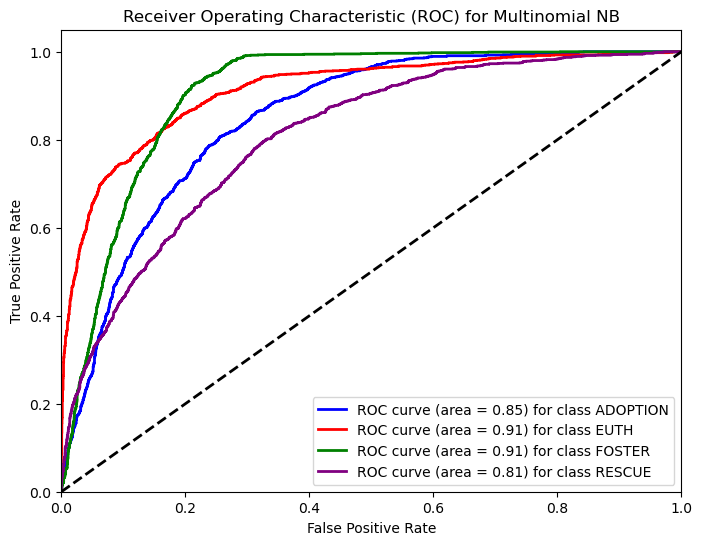

In [36]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Define the classes explicitly if known
classes = np.array(['ADOPTION', 'EUTH', 'FOSTER', 'RESCUE'])  # Replace with actual labels
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc_class = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob_test[:, i])
    roc_auc_class[i] = roc_auc_score(y_test_binarized[:, i], y_pred_prob_test[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc_class[i], classes[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multinomial NB')
plt.legend(loc="lower right")
plt.show()


In [37]:
# Predict classes on testing set
y_pred = mod.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    ADOPTION       0.56      0.64      0.60      1314
        EUTH       0.75      0.72      0.73      1388
      FOSTER       0.63      0.82      0.71      1398
      RESCUE       0.63      0.38      0.47      1395

    accuracy                           0.64      5495
   macro avg       0.64      0.64      0.63      5495
weighted avg       0.64      0.64      0.63      5495



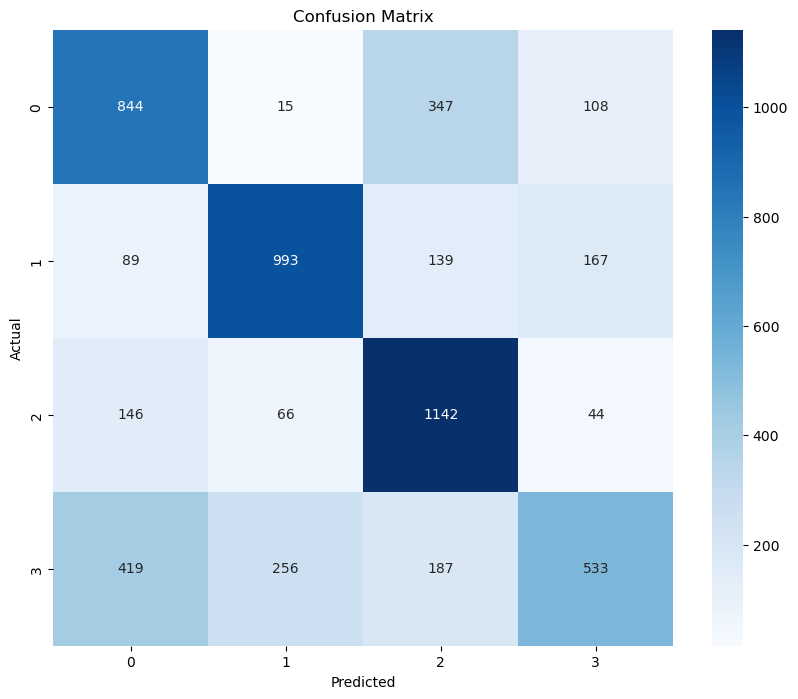

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [39]:
print("Matthews Correlation Coefficient (MCC):", matthews_corrcoef(y_test, y_pred))

Matthews Correlation Coefficient (MCC): 0.5249056429653929
